<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/1215_LSTM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7.5 LSTM

RNN의 결정적 단점은 가중치가 업데이트되는 과정에서 기울기가 1보다 작은 값이 계속 곱해지기 때문에, 기울기가 사라지는 기울기 소멸 문제가 발생함. 이를 해결하기 위한 방식 중 하나가 LSTM

1. 순전파 과정

LSTM은 기울기 소멸 문제를 해결하기 위해 망각 게이트, 입력 게이트, 출력 게이트라는 새로운 요소를 은닉층의 각 뉴런에 추가함.

## 망각게이트

과거 정보를 어느 정도 기억할지 결정. 과거 정보와 현재 데이터를 입력받아 시그모이드를 취한 후, 그 값을 과거 정보에 곱해 줌 -> 시그모이드 출력 0이면 과거 정보 버리고, 1이면 과거 정보 보존

## 입력게이트

현재 정보를 기억하기 위해 만들어진 것으로, 과거 정보와 현재 데이터를 입력받아 시그모이드와 하이퍼볼릭 탄젠트 함수를 기반으로 현재 정보에 대한 보존량을 결정함. 즉, 현재 메모리에 새로운 정보를 반영할지 결정하는 역할을 함.

- 계산한 값이 1이면 입력 x가 들어올 수 있도록 허용
- 계산한 값이 0이면 차단

## 셀

각 단계에 대한 은닉 노드를 메모리 셀이라고 함. 총합을 사용하여 셀 값을 반영하며, 이것으로 기울기 소멸 문제가 해결됨.

망각 게이트와 입력 게이트의 이전 단계 셀 정보를 계산하여 현재 단계의 셀 상태를 업데이트함.

## 출력게이트

과거 정보와 현재 데이터를 사용하여 뉴런의 출력을 결정함. 이전 은닉 상태와 t번째 입력을 고려해서 다음 은닉 상태를 계산함. 그리고 LSTM에서는 이 은닉 상태가 그 시점에서의 출력이 됨.

- 계산한 값이 1이면 의미 있는 결과로 최종 출력
- 계산한 값이 0이면 해당 연산 출력을 하지 않음.

## LSTM 역전파

LSTM은 셀을 통해서 역전파를 수행하기 때문에 중단 없는 기울기라고도 함. 즉, 최종 오차는 모든 노드에 전파되며, 이때 셀을 통해서 중단 없이 전파됨. 주의할 점은 입력 방향으로 오차가 전파되지 않는 것이 아님. 셀 내부적으로는 오차가 입력으로 전파됨.

# 7.5.2 LSTM 셀 구현

MNIST 데이터 셋 사용

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(125)

In [ ]:
# 데이터 정규화 코드
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0))
])

In [ ]:
from torchvision.datasets import MNIST

download_root = '/chap07/MNIST_DATASET'

train_dataset = MNIST(download_root, transform = mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform = mnist_transform, train=True, download=True)
test_dataset = MNIST(download_root, transform = mnist_transform, train=False, download=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.63MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.72MB/s]


In [ ]:
# 데이터로더를 이용하여 내려받은 MNIST 파일을 메모리로 불러옴
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [ ]:
# LSTM 셀에 대한 네트워크를 구축, LSTM 셀에 집중한 네트워크
class LSTMCell(nn.Module):
  def __init__(self, input_size, hidden_size, bias=True):
    super(LSTMCell, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.x2h = nn.Linear(input_size, 4*hidden_size, bias = bias)
    self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias = bias)
    self.reset_parameters()

  def reset_parameters(self):
    std = 1.0 / math.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, x, hidden):
    hx, cx = hidden
    x = x.view(-1, x.size(1))

    gates = self.x2h(x) + self.h2h(hx)
    gates = gates.squeeze()
    ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

    ingate = F.sigmoid(ingate)
    forgetgate = F.sigmoid(forgetgate)
    cellgate = F.tanh(cellgate)
    outgate = F.sigmoid(outgate)

    cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
    hy = torch.mul(outgate, F.tanh(cy))

    return (hy, cy)

4 * hidden_size -> 은닉층의 뉴런에 4를 곱하는 이유는, gates.chunk(4,1)에 의해 네 개로 쪼개져서 각각 망각, 입력, 셀, 출력 게이트를 의미하는 변수에 저장됨. 즉, gates가 네 개로 쪼개지는 상황이기 때문에 4가 곱해지는 것임.

- uniform()은 난수를 위해 사용, 실수의 난수 생성
- torch.squeeze()는 텐서의 차원을 줄이고자 할 때 사용
- torch.mul()은 텐서에 곱셈을 할 때 사용

In [ ]:
from torch.cuda import is_available
# LSTM 셀의 전반적인 네트워크
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim

    self.layer_dim = layer_dim
    self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self,x):
    if torch.cuda.is_available():
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    if torch.cuda.is_available():
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
    else:
      c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

    outs = []
    cn = c0[0,:,:]
    hn = h0[0,:,:]

    for seq in range(x.size(1)):
      hn,cn = self.lstm(x[:,seq,:], (hn,cn))
      outs.append(hn)

    out = outs[-1].squeeze()
    out = self.fc(out)
    return out

In [ ]:
# 옵티마이저와 손실 함수
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim)
if torch.cuda.is_available():
  model.cuda()
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
# 모델 학습 및 성능 확인
seq_dim = 28
loss_list = []
iter = 0


for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = Variable(labels.cuda())
    else:
      images = Variable(images.view(-1, seq_dim, input_dim))
      labels = Variable(labels)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)

    if torch.cuda.is_available():
      loss.cuda()

    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())
    iter += 1

    if iter % 500 == 0:
      correct = 0
      total = 0
      for images, labels, in valid_loader:

        if torch.cuda.is_available():
          images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
          images = Variable(images.view(-1, seq_dim, input_dim))

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        if torch.cuda.is_available():
          correct += (predicted.cpu() == labels.cpu()).sum()
        else:
          correct += (predicted == labels).sum()

        accuracy = 100 * correct / total
      print("Iteration: {}. Loss: {}. Accuracy: {}".format(iter, loss.item(), accuracy))


Iteration: 500. Loss: 2.237457752227783. Accuracy: 21.3700008392334
Iteration: 1000. Loss: 0.9968994855880737. Accuracy: 75.17666625976562
Iteration: 1500. Loss: 0.42673951387405396. Accuracy: 88.15166473388672
Iteration: 2000. Loss: 0.30981600284576416. Accuracy: 93.1933364868164
Iteration: 2500. Loss: 0.055824875831604004. Accuracy: 95.49333190917969
Iteration: 3000. Loss: 0.09873701632022858. Accuracy: 95.67333221435547
Iteration: 3500. Loss: 0.08254366368055344. Accuracy: 96.8116683959961
Iteration: 4000. Loss: 0.03308983892202377. Accuracy: 97.36166381835938
Iteration: 4500. Loss: 0.049307387322187424. Accuracy: 97.23332977294922
Iteration: 5000. Loss: 0.08068697899580002. Accuracy: 97.11333465576172
Iteration: 5500. Loss: 0.12790139019489288. Accuracy: 97.72833251953125
Iteration: 6000. Loss: 0.007093743421137333. Accuracy: 98.06666564941406
Iteration: 6500. Loss: 0.011727365665137768. Accuracy: 97.97333526611328
Iteration: 7000. Loss: 0.008610537275671959. Accuracy: 98.474998474

In [ ]:
def evaluate(model, val_iter):
  corrects, total, total_loss = 0, 0, 0
  model.eval()
  for images, labels in val_iter:

    if torch.cuda.is_available():
      images = Variable(images.view(-1, seq_dim, input_dim).cuda())
      labels = labels.cuda()
    else:
      images = Variable(images.view(-1, seq_dim, input_dim)).to(device)
      labels = labels.to(device)

    logit = model(images).to(device)
    loss = F.cross_entropy(logit, labels, reduction = 'sum')
    _, predicted = torch.max(logit.data, 1)
    total += labels.size(0)
    total_loss += loss.item()
    corrects += (predicted == labels).sum()

  avg_loss = total_loss / len(val_iter.dataset)
  avg_accuracy = corrects / total
  return avg_loss, avg_accuracy

In [ ]:
# 모델 예측 성능 확인
test_loss, test_acc = evaluate(model, test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


# 7.5.3 LSTM 계층 구현

스타벅스 주가 데이터세트를 통해 LSTM 계층 예제 수행

In [28]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
!git clone https://github.com/gilbutITbook/080289.git

fatal: destination path '080289' already exists and is not an empty directory.


In [35]:
data=pd.read_csv("/content/080289/chap07/data/SBUX.csv")
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


Data 칼럼은 인덱스로 사용. 단어들로 구성된 데이터셋은 임베딩 과정을 거쳐야 하는데, 날짜 칼럼은 임베딩으로 처리가 어려운 경우가 많아 인덱스로 처리하면 편함

In [36]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)

In [37]:
data['Volume'] = data['Volume'].astype(float)

In [38]:
# 데이터셋을 훈련과 정답으로 분리
X = data.iloc[:,:-1]
y = data.iloc[:, 5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [39]:
# 데이터 간 분포가 다르므로 표준화
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Traing Shape", X_train.shape, y_train.shape)
print("Test Shape", X_test.shape, y_test.shape)

Traing Shape (200, 5) (200, 1)
Test Shape (53, 5) (53, 1)


모든 데이터셋은 그 자체로 네트워크에 보낼 수 없기 땨문에 네트워크에서 정의된 형태 및 크기에 따라 데이터셋 크기를 조정 후 네트워크로 보내야 함

In [40]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors, (X_train_tensors.shape[0],
                                                  1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors, (X_test_tensors.shape[0],
                                                 1, X_test_tensors.shape[1]))

print('Training Shape', X_train_tensors_f.shape, y_train_tensors.shape)
print('Testing Shape', X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [43]:
# LSTM 네트워크
class LSTM(nn.Module) :
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length) :
        super(LSTM, self).__init__()
        self.num_classes = num_classes # 클래스 개수
        self.num_layers = num_layers # LSTM 계층 개수
        self.input_size = input_size # 입력 크기로 훈련 데이터셋의 칼럼 개수를 의미
        self.hidden_size = hidden_size # 은닉층 뉴런 개수
        self.seq_length = seq_length # 시퀀스 길이

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                           num_layers=num_layers, batch_first=True) # LSTM 계층
        self.fc_1 = nn.Linear(hidden_size, 128) # 완전연결층
        self.fc = nn.Linear(128, num_classes) # 출력층
        self.relu = nn.ReLU()

    def forward(self, x) :
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 은닉상태를 0으로 초기화
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # 셀 상태를 0으로 초기화
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # LSTM 계층에 은닉 상태와 셀 상태 적용
        hn = hn.view(-1, self.hidden_size) # 완전연결층 적용을 위해 데이터의 형태 조정(1차원으로 조정)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [44]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5 # 입력 데이터셋의 칼럼 개수
hidden_size = 2 # 은닉층의 뉴런/유닛 개수
num_layers = 1 # LSTM 계층의 개수

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers,
             X_train_tensors_f.shape[1]) # 앞에서 정의한 값들을 이용하여 LSTM 모델 학습

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
# 모델 학습
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0 :
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08108
Epoch: 100, loss: 0.03915
Epoch: 200, loss: 0.03558
Epoch: 300, loss: 0.03305
Epoch: 400, loss: 0.03167
Epoch: 500, loss: 0.03100
Epoch: 600, loss: 0.03052
Epoch: 700, loss: 0.02995
Epoch: 800, loss: 0.02921
Epoch: 900, loss: 0.02844


In [46]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

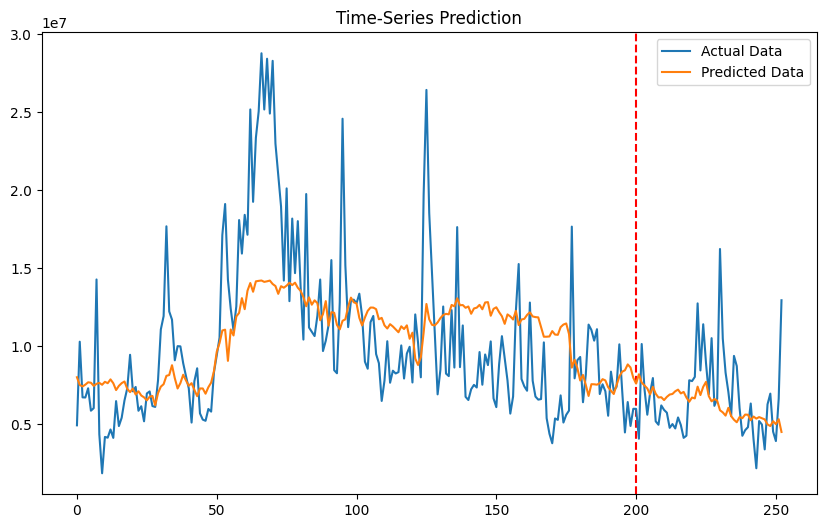

In [47]:
# 전처리 진행된 데이터를 그래프로 출력

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

파란색은 실제 레이블에 대한 출력 결과이고 주황색은 모델 예측 결과를 보여 줌. 성능이 별로 좋지 않은 것으로 볼 때, 하이퍼 파라미터 조정보단 모델 변경 권장.